# Bayesian Learning Exam

Quentin Le Roux

<hr><hr><hr>

## Library Imports

<u>Note on PyStan:</u> For the purpose of this exercise, HMC will be implemented with the 2.xx version of the Python interface of the Stan library (https://mc-stan.org, https://pystan.readthedocs.io/en/latest/). To set it up:

```sh
$ conda create -n pystan_env python=3.6 ipykernel matplotlib seaborn scipy numpy pandas pystan=2.19.0.0
$ conda activate pystan_env
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan # RELIES ON PYSTAN 2
import seaborn as sns 

from pystan.constants import MAX_UINT
from scipy.special import logsumexp
from scipy.stats import gaussian_kde
from scipy.stats import norm, uniform, binom
from scipy.stats import multivariate_normal

pd.set_option('mode.chained_assignment', None)

%run ./tools.py

## Exercise 1

Consider the following bivariate distribution:

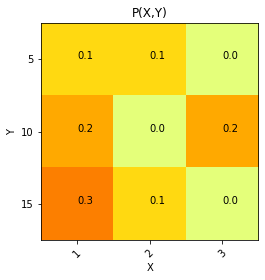

In [240]:
import matplotlib.pyplot as plt
import numpy as np

freq = [[0.1,0.1,0.],[0.2,0.,0.2],[0.3,0.1,0.]]

plt.clf()
plt.imshow(freq, interpolation='nearest', cmap=plt.cm.Wistia)
X_values = ['1','2','3']
Y_values = ['5','10','15']
plt.ylabel('Y')
plt.xlabel('X') 
plt.title('P(X,Y)') 
plt.xticks(np.arange(len(X_values)), X_values, rotation=45)
plt.yticks(np.arange(len(Y_values)), Y_values)
for i in range(len(X_values)):
    for j in range(len(Y_values)):
        plt.text(j,i, str(freq[i][j]))
plt.show()

### 1) Show that P(X,Y) is a valid distribution function.
We are dealing with two random variables, $X$ and $Y$, and are looking to quantify the probability associated to their joint realization (i.e. quantifying their joint probability function). In this exercise, we are interested in the variable $X$ jointly with the variable $Y$. The variable $X$ takes values in $\Omega^X = \{1, 2, 3\}$, while the variable $Y$ in $\Omega^Y = \{5, 10, 15\}$. The joint probability for these discrete quantities is assigned in terms of the frequency table displayed above.

The table represents the joint probability mass function $\mathbb{P}(X,Y)$, for each value of the random variables. We note that both random variables are discrete and as such the joint distribution will take a finite number of values as well.

We know that the joint probability mass function follows the standard requirements for a probability function:

1. Each element/joint probability is comprised between 0 and 1
2. The sum of the elements/joint probabilities is equal to 1

As such we declare a function that helps us check those requirements (with two sanity checks):

In [241]:
def check_distribution_validity(freq):
    """
    Checks the two conditions that indicates that a list of frequencies
    conforms to the rules of a Joint Probability Mass function.
    """
    # Checks freqs in between 0 and 1
    flat_freqs = [item for sublist in freq for item in sublist]
    check_f = lambda x: 0<=x<=1
    count_true = sum(map(check_f, flat_freqs))
    interval_check = (count_true == len(flat_freqs))
    # Checks that freqs sum to 1
    sum_freqs = round(sum(flat_freqs), 15) # rounds to 15 dec. to avoid floating point errors
    sum_check = (sum_freqs == 1)
    return interval_check and sum_check

# Check for function fonctionality
print("Fail check on [[1, 0.5],[-1, 0.5]]:\t\t", 
      check_distribution_validity([[0, 1, -1, 2]]))
print("Success check on [[0.05, 0.5],[0.15, 0.3]]:\t", 
      check_distribution_validity([[0.05, 0.5],[0.15, 0.3]]))

Fail check on [[1, 0.5],[-1, 0.5]]:		 False
Success check on [[0.05, 0.5],[0.15, 0.3]]:	 True


In [242]:
print("Check on freqs", freq, ":", 
      check_distribution_validity(freq))

Check on freqs [[0.1, 0.1, 0.0], [0.2, 0.0, 0.2], [0.3, 0.1, 0.0]] : True


We confirm that the given frequencies form a valid distribution function.

### 2) Show that X and Y are not independent.

If the variables are independent, then the given joint probability distribution factorises across variables such that: $$p(X,Y)=p(X)p(Y)$$

To check whether $X$ and $Y$ are independent, we declare a function that performs the checks above for all possible combinations, in order to check for failure of the given independence condition.

In [243]:
def check_independence(freq):
    """
    Checks whether the random variables forming a joint probability
    distribution are independent of not
    """
    # Computes the marginal probability distributions of X and Y
    p_X = np.sum(freq, axis = 0)
    p_Y = np.sum(freq, axis = 1)
    print(f"Given the joint distribution of X and Y, we find:", 
          f"P_X: {p_X} (summing to {np.sum(p_X)})",
          f"P_Y: {p_Y} (summing to {np.sum(p_Y)})", 
          sep="\n")
    # checks whether P(X, Y) == P(X).P(Y)
    acc = 0
    for id_x, prob_x in enumerate(p_X):
        for id_y, prob_y in enumerate(p_Y):
            acc += p_X[id_x] * p_Y[id_y]
            p_XtimesY = round(p_X[id_x] * p_Y[id_y], 2)
            p_XY = freq[id_x][id_y]
            print(f"X = {X_values[id_x]}, Y = {Y_values[id_y]}: \t",
                  f"P_X.P_Y={p_XtimesY}, P_XY={p_XY} -- are equal?",
                  p_XtimesY == p_XY)
    # Returns the marginal probability distributions
    return p_X, p_Y

In [244]:
marginal_distributions = check_independence(freq)

Given the joint distribution of X and Y, we find:
P_X: [0.6 0.2 0.2] (summing to 1.0)
P_Y: [0.2 0.4 0.4] (summing to 1.0)
X = 1, Y = 5: 	 P_X.P_Y=0.12, P_XY=0.1 -- are equal? False
X = 1, Y = 10: 	 P_X.P_Y=0.24, P_XY=0.1 -- are equal? False
X = 1, Y = 15: 	 P_X.P_Y=0.24, P_XY=0.0 -- are equal? False
X = 2, Y = 5: 	 P_X.P_Y=0.04, P_XY=0.2 -- are equal? False
X = 2, Y = 10: 	 P_X.P_Y=0.08, P_XY=0.0 -- are equal? False
X = 2, Y = 15: 	 P_X.P_Y=0.08, P_XY=0.2 -- are equal? False
X = 3, Y = 5: 	 P_X.P_Y=0.04, P_XY=0.3 -- are equal? False
X = 3, Y = 10: 	 P_X.P_Y=0.08, P_XY=0.1 -- are equal? False
X = 3, Y = 15: 	 P_X.P_Y=0.08, P_XY=0.0 -- are equal? False


We prove that the condition $p(X,Y)=p(X)p(Y)$ does not hold for the variables $X$ and $Y$. As such we can confirm that $X$ and $Y$ are not independent.

### 3) Find the marginal distribution of X.

We already have computed the marginal distribution of the variable $X$ above. As such we can easily retrieve $P_X$ such that (we also check the distribution condition that it sums to 1):

In [245]:
marginal_distribution_X = {X_values[idx]:round(marginal_distributions[0][idx], 2)
                           for idx in range(len(X_values))}

print("Marginal distribution of X:"
      f"\n\t{marginal_distribution_X}",
      f"\n\tSums to: {sum(marginal_distribution_X.values())}")

Marginal distribution of X:
	{'1': 0.6, '2': 0.2, '3': 0.2} 
	Sums to: 1.0


### 4) Find P(X=2 | Y < 15).

We are looking for the conditional probability $P(X=2 | Y < 15)$ such that:

\begin{align}
X&\in\{1, 2, 3\}\\
y&\in\{5, 10, 15\}\\
P(X=2 | Y < 15) &= \frac{P(X=2, Y < 15)}{P(Y < 15)}\\
&= \frac{P(X=2, Y = 5 \cup Y = 10)}{P(Y = 5 \cup Y = 10)}\\
&= \frac{P(X=2, Y = 5) + P(X=2, Y = 10)}{\underset{X}{\sum}P(X, Y = 5 \cup Y = 10)}\\
&= \frac{P(X=2, Y = 5) + P(X=2, Y = 10)}{\underset{x=1}{\overset{3}{\sum}}P(X=x, Y = 5) + P(X=x, Y = 10)}\\
&= \frac{0.1+0}{0.1+0.1+0.2+0+0.2+0}\\
&=\frac{0.1}{0.6}\\
&=0.1666....
\end{align}

In [246]:
P_X2_Y5  = freq[0][1]
P_X2_Y10 = freq[1][1]
print(f"P(X=2, Y=5)={P_X2_Y5}\nP(X=2, Y=10)={P_X2_Y10}")

P_X_Ylt15 = sum([freq[y][x] for x in range(3) for y in range(2)])
P_X_Ylt15 = round(P_X_Ylt15,2)
print(f"\nP(X, Y<15)={P_X_Ylt15}")

P_X2_given_Ylt15 = (P_X2_Y5 + P_X2_Y10)/(P_X_Ylt15)
P_X2_given_Ylt15 = round(P_X2_given_Ylt15, 2)
print(f"\nP(X=2, Y<15)={P_X2_given_Ylt15}",
      "(rounded to 2-decimals due to floating point computation)")

P(X=2, Y=5)=0.1
P(X=2, Y=10)=0.0

P(X, Y<15)=0.6

P(X=2, Y<15)=0.17 (rounded to 2-decimals due to floating point computation)


We find that: $$P(X=2 | Y < 15) = 0.17$$

## Exercise 2

Let's suppose the following joint probability distribution is known for a medicine:

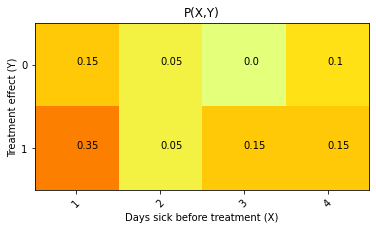

In [247]:
freq = [[0.15,0.05,0., 0.1],[0.35,0.05,0.15,0.15]]

plt.clf()
plt.imshow(freq, interpolation='nearest', cmap=plt.cm.Wistia)
X_values = ['1','2','3','4']
Y_values = ['0','1']
plt.ylabel('Treatment effect (Y)')
plt.xlabel('Days sick before treatment (X)') 
plt.title('P(X,Y)') 
plt.xticks(np.arange(len(X_values)), X_values, rotation=45)
plt.yticks(np.arange(len(Y_values)), Y_values)
for i in range(len(X_values)):
    for j in range(len(Y_values)):
        plt.text(i,j, str(freq[j][i]))
plt.show()

<u>Note:</u> Let Y represent the treatment outcome (0 = not recovered, 1 = recovered) and X represent the number of days sick before treatment. Find:

### 1) P(Y=1)

We have: 
\begin{align}
P(Y=1) &= P(X=1\cup X=2\cup X=3\cup X=4, Y=1)\\
&= \underset{x=1}{\overset{4}{\sum}}P(X=x, Y=1)\\
&= P(X=1, Y=1) + P(X=2, Y=1) + P(X=3, Y=1) + P(X=4, Y=1)\\
&= 0.35 + 0.05 + 0.15 + 0.15\\
&= 0.7
\end{align}

In [248]:
print(f"P(X=x|Y=1)={freq[1]}",
      f"P(Y=1)=sum(P(X=x|Y=1))={np.sum(freq[1])}",
      sep="\n")

P(X=x|Y=1)=[0.35, 0.05, 0.15, 0.15]
P(Y=1)=sum(P(X=x|Y=1))=0.7


We find that: $$P(Y=1) = 0.7$$

### 2) P(Y=1 | X=3)

\begin{align}
P(Y=1 | X=3) &= \frac{P(Y=1, X=3)}{P(X=3)}\\
&= \frac{0.15}{\underset{Y}{\sum}P(X=3, Y)}\\
&= \frac{0.15}{P(X=3, Y=0)+P(X=3, Y=1)}\\
&= \frac{0.15}{0.0 + 0.15}\\
&=1
\end{align}

In [249]:
P_Y1_X3 = freq[1][2]
print(f"P(Y=1, X=3)={P_Y1_X3}")

P_X3 = np.sum(freq, axis=0)[2]
print(f"P(X=3)={P_X3}")

print(f"P(Y=1|X=3)={P_Y1_X3/P_X3}")

P(Y=1, X=3)=0.15
P(X=3)=0.15
P(Y=1|X=3)=1.0


We find that: $$P(Y=1 | X=3)=1$$

### 3) P(Y=1 | X>=3)

\begin{align}
P(Y=1 | X>=3) &= \frac{P(Y=1, X>=3)}{P(X>=3)}\\
P(Y=1 | X>=3) &= \frac{P(Y=1, X=3\cup X=4)}{P(X>=3)}\\
&= \frac{0.15 + 0.15}{\underset{Y}{\sum}P(X>=3, Y)}\\
&= \frac{0.3}{P(X=3, Y=0)+P(X=3, Y=1)+P(X=4, Y=0)+P(X=4, Y=1)}\\
&= \frac{0.3}{0.0 + 0.15 + 0.1 + 0.15}\\
&= \frac{0.3}{0.4}\\
&= 0.75
\end{align}

In [250]:
P_Y1_Xsupp3 = np.sum(freq[1][2:])
print(f"P(Y=1, X>=3)={P_Y1_Xsupp3}")

P_Xsupp3 = sum(np.sum(freq, axis=0)[2:])
print(f"P(X=3)={P_Xsupp3}")

print(f"P(Y=1|X=3)={round(P_Y1_Xsupp3/P_Xsupp3, 2)}",
      "(rounded to 2-decimals due to floating point computation)")

P(Y=1, X>=3)=0.3
P(X=3)=0.4
P(Y=1|X=3)=0.75 (rounded to 2-decimals due to floating point computation)


We find that: $$P(Y=1 | X>=3) = 0.75$$

### 4) P(X=2 | Y=0)

\begin{align}
P(X=2 | Y=0) &= \frac{P(X=2, Y=0)}{P(Y=0)}\\
&= \frac{P(X=2, Y=0)}{\overset{4}{\underset{x=1}{\sum}}P(X=x,Y=0)}\\
&= \frac{0.05}{0.15+0.05+0.0+0.1}\\
&= \frac{0.05}{0.3}\\
&= 0.166...
\end{align}

In [251]:
P_X2_Y0 = freq[0][1]
print(f"P(X=2, Y=0)={P_X2_Y0}")

P_Y0 = round(np.sum(freq[0]),2)
print(f"P(Y=0)={P_Y0}")

print(f"P(X=2|Y=0)={round(P_X2_Y0/P_Y0,2)}",
      "(rounded to 2-decimals due to floating point computation)")

P(X=2, Y=0)=0.05
P(Y=0)=0.3
P(X=2|Y=0)=0.17 (rounded to 2-decimals due to floating point computation)


We find that: $$P(X=2|Y=0)=0.17$$

### 5) P(X<=2 | Y=0)

\begin{align}
P(X\le2 | Y=0) &= \frac{P(X\le2, Y=0)}{P(Y=0)}\\
&= \frac{\overset{2}{\underset{x=1}{\sum}}P(X=x,Y=0)}{\overset{4}{\underset{x=1}{\sum}}P(X=x,Y=0)}\\
&= \frac{0.15 + 0.05}{0.15+0.05+0.0+0.1}\\
&= \frac{0.2}{0.3}\\
&= 0.666...
\end{align}

In [252]:
P_Xle2_Y0 = sum(freq[0][:2])
print(f"P(X<=2, Y=0)={P_Xle2_Y0}")

P_Y0 = round(np.sum(freq[0]),2)
print(f"P(Y=0)={P_Y0}")

print(f"P(X<=2|Y=0)={round(P_Xle2_Y0/P_Y0,2)}",
      "(rounded to 2-decimals due to floating point computation)")

P(X<=2, Y=0)=0.2
P(Y=0)=0.3
P(X<=2|Y=0)=0.67 (rounded to 2-decimals due to floating point computation)


We find that: $$P(X<=2|Y=0)=0.67$$

## Exercise 3

A hospital has 5 ambulances, two of them have one bed inside while the rest have two beds inside. Let X = number of two beds ambulances used on any given day and Y = number of one bed ambulances used on any given day.

Suppose the joint probability of X and Y is as follows:

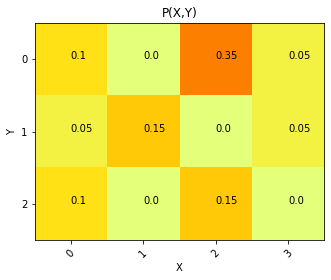

In [253]:
freq = [[0.1,0.0,0.35, 0.05],[0.05,0.15,0.,0.05],[0.10, 0.0, 0.15,0.0]]

plt.clf()
plt.imshow(freq, interpolation='nearest', cmap=plt.cm.Wistia)
X_values = ['0','1','2','3']
Y_values = ['0','1', '2']
plt.ylabel('Y')
plt.xlabel('X') 
plt.title('P(X,Y)') 
plt.xticks(np.arange(len(X_values)), X_values, rotation=45)
plt.yticks(np.arange(len(Y_values)), Y_values)
for i in range(len(X_values)):
    for j in range(len(Y_values)):
        plt.text(i,j, str(freq[j][i]))
plt.show()

Find the probability that, on any given day:

### 1) None of the ambulances are hired.

That none of the ambulances are hired corresponds to the joint probability that $X=0$ and $Y=0$. As such, we want to compute: $$P(X=0, Y=0)$$
As such:
\begin{align}
P(X=0, Y=0) &= 0.1
\end{align}

In [254]:
P_X0_Y0 = freq[0][0]
print(f"P(X=0, Y=0)={P_X0_Y0}")

P(X=0, Y=0)=0.1


### 2) All of the one bed ambulances are hired.

That all the one-bed ambulances are hired corresponds to the probability that $Y=2$ (i.e. the maximum number of available one-bed ambulances). As such, we want to compute: 

\begin{align}
P(Y=2)&=\underset{Y}{\sum}P(Y=2, X)\\
&= P(Y=2, X=0) + P(Y=2, X=1) + P(Y=2, X=2) + P(Y=2, X=3)\\
&= 0.1 + 0.0 + 0.15 + 0.0\\
&=0.25
\end{align}

In [255]:
# computes the marginal distribution of Y
marginal_distribution_Y = np.sum(freq, axis=1)

P_Y2 = marginal_distribution_Y[-1]
print(f"P(Y=2)={P_Y2}")

P(Y=2)=0.25


###  3) At least 2 of the ambulances are hired.

That at least 2 of the ambulances (regardless of their bed number) are hired corresponds to the probability that $X+Y\ge2$. As such, we want to compute:

\begin{align}
P(X+Y\ge2)&=P(Y=0,X\ge2) + P(Y=1,X\ge1) + P(Y=2, X\ge0)\\
&=\underset{x=2}{\overset{3}{\sum}}P(Y=0,X=x) + \underset{x=1}{\overset{3}{\sum}}P(Y=1,X=x) + \underset{x=0}{\overset{3}{\sum}}P(Y=2,X=x)\\
&=(0.35 + 0.05)+(0.15+0+0.05)+(0.1+0+0.15+0)\\
&= 0.85
\end{align}

In [256]:
P_Y0_Xge2 = round(sum(freq[0][2:]),2)
print(f"P(Y=0, X>=2)={P_Y0_Xge2}")

P_Y1_Xge1 = sum(freq[1][1:])
print(f"P(Y=1, X>=1)={P_Y1_Xge1}")

P_Y2_Xge0 = sum(freq[2])
print(f"P(Y=2, X>=0)={P_Y2_Xge0}")

print(f"P(X+Y>=2)={round(P_Y0_Xge2 + P_Y1_Xge1 + P_Y2_Xge0, 2)}")

P(Y=0, X>=2)=0.4
P(Y=1, X>=1)=0.2
P(Y=2, X>=0)=0.25
P(X+Y>=2)=0.85


###  4) All of the one bed ambulances are hired, if all the 2 beds ambulances have been hired. Compare your answer to (2) and reason whether X and Y are independent.

That given all the two-bed ambulances have been hired (i.e. $X=3$), that all the one-bed ambulances are also hired (i.e. $Y=2$) corresponds to the conditional probability: $$P(Y=2|X=3)=\frac{P(X=3, Y=2)}{P(X=3)}$$
As such:
\begin{align}
P(Y=2|X=3)&=\frac{P(X=3, Y=2)}{P(X=3)}\\
&=\frac{0.0}{P(X=3)}\\
&=0
\end{align}

In [257]:
P_X3_Y2 = freq[2][3]
print(f"P(X=3, Y=2)={P_X3_Y2}")

marginal_distribution_X = np.sum(freq, axis=0)
P_X3 = marginal_distribution_X[-1]
print(f"P(X=3)={P_X3}")

P_Y2_given_X3 = P_X3_Y2/P_X3
print(f"P(Y=2|X=3)={P_Y2_given_X3}")

P(X=3, Y=2)=0.0
P(X=3)=0.1
P(Y=2|X=3)=0.0


## Exercise 4

Let's consider the following data:

(2, 352)


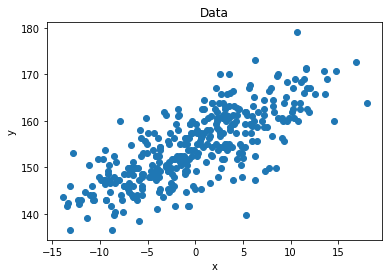

In [258]:
import pandas as pd
%run ./tools.py

data = np.load('./data_exercise4.npy')
print(data.shape)
x = data[0,:] - np.mean(data[0,:])
y = data[1,:]

plt.scatter(x,y)
plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

df = pd.DataFrame({'x':x, 'y':y})

According to the plot above, a linear relationship seems to exist between x and y. Therefore, we model the data according to $y_i = \mathcal{N}(\mu_i, \sigma^{2})$ with $\mu_i = a + b*x_i$. We find a posterior distribution for the parameters a, b and $\sigma^{2}$ using a Laplace approximation.

In [259]:
expr = 'y ~ x'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 10
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 1
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 20
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, df, likelihood, priors)

/home/quentin/anaconda3/envs/pystan_env/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/envs/pystan_env/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 2543.5778329132754
 hess_inv: array([[ 0.92705229,  0.02558759, -0.39382393],
       [ 0.02558759,  0.12677868,  0.07180338],
       [-0.39382393,  0.07180338,  1.20687006]])
      jac: array([ -2.38366699,  -0.55059814, -15.01779175])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 77
      nit: 6
     njev: 17
   status: 2
  success: False
        x: array([17.74091013,  0.54785936, 68.97867495])


### 1) Examine the posterior distribution for the regression parameters, and decide if the solution is correct or not.

We first of all note that the optimization process provided by scipy mentions that it has failed (quote: `success: False`).

1) **Exploring the priors of the model**

In [68]:
def explore_data(data, name=""):
    """
    Explores the distribution and statistics of a given data
    """
    print(f"mean of {name}: ", round(np.mean(data), 10),
          "(rounded to 10 decimals)")
    print(f"standard deviation of {name}: ", round(np.std(data), 10),
          "(rounded to 10 decimals)")
    print(f"density plot of the data {name}")
    sns.kdeplot(data)

mean of x:  0.0 (rounded to 10 decimals)
standard deviation of x:  6.4475301238 (rounded to 10 decimals)
density plot of the data x


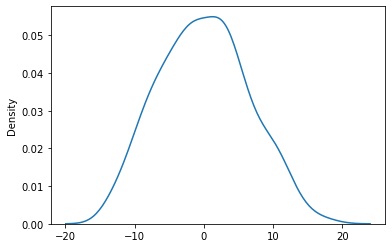

In [69]:
explore_data(x, "x")

mean of y:  154.5970926136 (rounded to 10 decimals)
standard deviation of y:  7.7313266845 (rounded to 10 decimals)
density plot of the data y


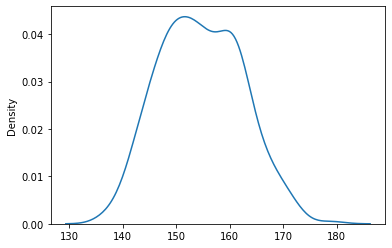

In [70]:
explore_data(y, "y")

Our first observation is that the priors used for the Laplace approximation model above, and reproduced below, are quite far away from the statistics of the data $x$ shown above along with a density plot.

```python
prior_a_mean = 10
prior_a_sigma = 1
prior_b_mean = 0
prior_b_sigma = 1
```

Given the first plot above, we would expect a higher prior for $a$ for instance. Furthermore, since it seems , visually, that there is a positive linear relationship between $x$ and $y$, we could see changing the prior of $b$ to a slightly positive vale.

2) **Assessment of the posterior distribution for the regression parameters**

We reuse functions declared in the assignment 2 to perform the assessment of the posterior distribution for the regression parameters

In [71]:
def posterior_sampling_laplace(
    solution: list, 
    n_samples: int
) -> list:
    """
    Computes a sampling of a posterior distribution
    yielded from a Laplace approximation.
    """
    posterior_samples = multivariate_normal.rvs(
        solution[0], solution[1], size = n_samples
    )
    return posterior_samples
    
def sampling_from_posterior(
    data: pd.DataFrame, 
    mean_covariate: float, 
    depvar_name: str, 
    covar_name: str, 
    posterior_samples: multivariate_normal.rvs,
    posterior_means: list,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str
) -> None:
    """
    Samples datapoints from a posterior distribution and plots the 
    resulting distribution.
    """
    # Samples from the posterior
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = posterior_means[0] + posterior_means[1] * x_range
    for i in range(len(posterior_samples)):
        prediction = posterior_samples[i,0] + \
                     posterior_samples[i,1] * x_range
        plt.plot(x_range + mean_covariate, prediction, 
                 lw = 0.05, color = 'grey')
    # Plots the resulting plot
    plt.scatter(data[covar_name] + mean_covariate, data[depvar_name])
    plt.plot(x_range + mean_covariate, mean_prediction, 
             lw = 2, color = 'black')
    plt.title(plot_title)
    plt.ylabel(plot_ylabel)
    plt.xlabel(plot_xlabel)
    plt.show()

def summarize(
    solution: list, 
    n_samples: int,
    names: dict={0:'a',1:'b', 2:'sigma'}, 
    plot: bool=False,
) -> tuple:
    """
    Summarizes the regression statistics obtained via a
    Laplace approximation.
    """
    # Computes posterior samples
    posterior_samples = posterior_sampling_laplace(
        solution, n_samples
    )
    #### Computes summary stats
    #    85% confidence interval
    post_quantiles = np.quantile(posterior_samples, 
                                 q = [0.075, 0.925], 
                                 axis = 0)
    #    standard deviation
    post_sd = np.std(posterior_samples, axis = 0)
    #     mean
    post_mean = np.mean(posterior_samples, axis = 0)
    # Prints the results
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],
                     post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.rename(index=names, inplace=True)
    print(summary_stats, "\n")
    # If requested, prints the plot of the posterior data
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()
    # Returns the posterior samples
    return post_mean, post_sd, posterior_samples

In [72]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution_regression, n_samples=1000)

            mean        SD       7.5%      92.5%
a      16.769443  0.936158  15.479938  18.096643
b      -0.023272  0.250179  -0.383239   0.324064
sigma  68.528852  1.028976  67.085864  70.021038 



We see that the resulting regression solution provides a distribution for the parameters $a$ and $b$ that do not match our observations.

- Given that for $x\approx0$, we seem to find values for $y$ around 150 in the dataset
- Given then that the intercept $a$'s 95% confidence interval is c. [9.3, 12.0]
- Given that we visually seem to evidence a positive linear trend between $x$ and $y$
- Given then that the coefficient $b$'s mean is -0.9 and 95% confidence interval in [-1.8, 0.1]
- Given that, as noted, the optimization process provided by scipy mentions that it has failed (quote: `success: False`).

We can confidently state that the resulting regression model does not match our cursory observations and as such the model surely is not correct.

### 2) In case there is any problem with the model, modify the code above in order to get a proper solution

It seems that our previous model fails due to mis-declared priors. As such, we are looking for better values to declare our regression. Based on our previous observation, we decide:

- To increase the prior mean and standard deviation for the intercept $a$ (from 10 and 1 to 170 and 1, which matches more closely our observation of the distribution of $y$ seen above). 
- To leave unchange the prior mean for the coefficient $b$ but to increase its prior standard deviation (from 1 to 10) to allow for more variabilty in the model's run
- To reduce the lower bound for the model's $\sigma$ from 20 to 0 to increase the overall range of the underlying uniform distribution function


In [73]:
expr = 'y ~ x'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 150
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, df, likelihood, priors)

/home/quentin/anaconda3/envs/pystan_env/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 1081.4766154094232
 hess_inv: array([[ 7.52534511e-02,  2.20773412e-04,  5.32096339e-04],
       [ 2.20773412e-04,  1.78378246e-03, -1.35220801e-05],
       [ 5.32096339e-04, -1.35220801e-05,  3.81832202e-02]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 86
      nit: 17
     njev: 21
   status: 0
  success: True
        x: array([154.59373637,   0.90501319,   5.07186734])


We thus obtain a successful regression solution (`success: True`).

## Exercise 5

Consider the following function on the interval [0, 3]:

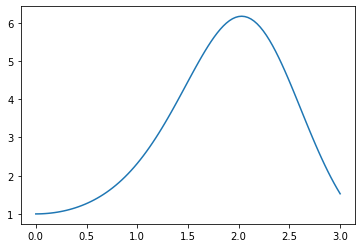

In [260]:
x = np.linspace(0., 3., 100)
f = np.exp(x*np.sin(x))

plt.plot(x, f)
plt.show()

### 1) Approximate this function using the Laplace approximation.

The Laplace method approximates the shape of a given function with a Gaussian distribution. This approximation relies on the Taylor expansion of the (log-)function of interest *f* with *f* the function to approximate. Thus, we state the function *g* such that:

$$f(x) = \exp(\log(f(\theta)) = \exp(g(\theta))$$

Stopping at the second order, and assuming that *g* and *f* share a maximum in $\theta_0$, we can approximate *g* and thus *f* for any point $\theta$ sufficiently close to $\theta_0$ such that:

\begin{align}
g(\theta) &= g(\theta_0) + g'(\theta_0)(\theta-\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2 + o((\theta - \theta_0)^3)\\
g'(\theta_0) &= 0 \\
\end{align}

We find the following approximation:

\begin{align}
g(\theta) &\approx g(\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\\
f(\theta_0) &\approx f(\theta_0) + \exp(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2) \\
&\approx \exp\big(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\big)\quad\text{Given $f(\theta_0)$ a constant}\\
&\approx \exp\big(-\frac{1}{2}\frac{(\theta-\theta_0)^2}{-\frac{1}{g''(\theta_0)}}\big)\quad\text{We recognize a Gaussian PDF}\\
\end{align}

As such, *f* can be approximated (up to a normalization constant) by a Gaussian distribution: 

$$\mathcal{N}(\theta_0, -\frac{1}{g''(\theta_0)})$$

<u>Computing the maximum of the log-distribution:</u>

Given above the function $f(x) = exp(x*sin(x))$, we can state:

\begin{align}
g(\theta) & = \log(f(\theta)) = \theta * sin(\theta)\\
\frac{\delta g}{\delta \theta} &= sin(\theta) + \theta*cos(\theta) \quad\text{Obtained via Wolfram Alpha}
\end{align}

As such:

\begin{align}
g'(\theta_0) &= 0\\
&\Rightarrow x = \{-2, 0, 2\} \quad\text{Obtained via Wolfram Alpha}
\end{align}

Since we are looking at the interval $[0,3]$, we select: $$\theta_0 = 2$$

<u>Computing the second derivative of the log-distribution with respect to $\theta$:</u>

\begin{align}
\frac{\delta^2 g}{\delta \theta^2} &= 2*cos(\theta) - \theta*sin(\theta) \quad\text{Obtained via Wolfram Alpha}
\end{align}

We find:

$$g''(\theta_0) = 2*cos(2) - 2*sin(2)$$

<u>Concluding on finding the Laplace approximation :</u>

The approximation will be the Gaussian:

$$\mathcal{N}\big(2, \frac{1}{2*cos(2) - 2*sin(2)}\big)$$

### 2) Plot the original function and your approximation on the same graph.

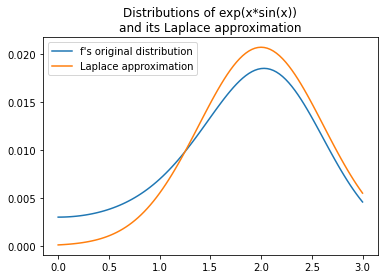

In [261]:
def lapproximation():
    """
    Returns the Laplace approximation of the distribution of 
    exp(x*sin(x)).
    """
    theta_max = 2
    hessian   = (2*np.cos(2)-2*np.sin(2))
    variance  = -1/hessian
    return norm(theta_max, np.sqrt(variance))

plt.figure()
plt.plot(x, f/np.sum(f), 
         label="f's original distribution")
plt.plot(x, lapproximation().pdf(x)/np.sum(lapproximation().pdf(x)), 
         label="Laplace approximation")
plt.title("Distributions of exp(x*sin(x))\nand its Laplace approximation")
plt.legend()
plt.show()

## Exercise 6

From the file grades.csv we are interested in predicting the final evaluation score from the midterm one. 

### (6.1) Find appropriate priors for a linear model. Sample from the priors to verify that the choice of all the priors parameters is compatible with the regression problem

1. **Data import**

In [262]:
data = pd.read_csv("grades.csv", sep=",")
data.describe()

,student,midterm,final
count,52.000000,52.000000,52.000000
mean,26.500000,78.596154,119.807692
std,15.154757,9.632990,16.102659
min,1.000000,53.000000,78.000000
25%,13.750000,71.000000,115.500000
50%,26.500000,79.000000,122.000000
75%,39.250000,88.000000,130.250000
max,52.000000,96.000000,145.000000


2. **Setup**

We are interested in a possible relationship between the final scores and the midterm scores of the student in the dataset. We may define a preliminary model as a linear regression with `final score` as the dependent variable and `midterm score` as the covariate. 

We are interested in the regression function $r$ such that:

$$r \rightarrow \mathbb{E}[final\,score\,\,|\,\,midterm\,score]$$

Our resulting linear model would be as such:

\begin{align}
\text{final score} &= a+b*\text{midterm score}\\\\
\text{with,}\\
a&,\text{ the intercept}\\
b, &,\text{ the coefficient of the covariate 'midterm score'}
\end{align}

3. **Data Exploration**

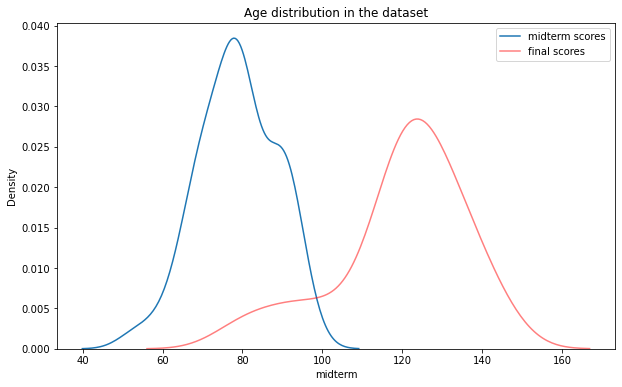

In [263]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["midterm"], label="midterm scores").set(title='Age distribution in the dataset')
sns.kdeplot(data["final"], label="final scores",color="red", alpha=0.5)
plt.legend()
plt.show()

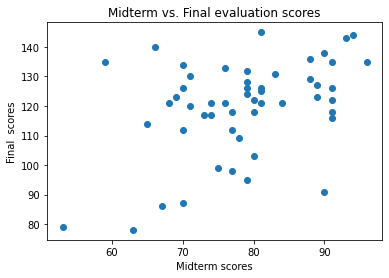

In [264]:
plt.figure()
plt.scatter(data["midterm"], data["final"])
plt.title("Midterm vs. Final evaluation scores")
plt.xlabel("Midterm scores")
plt.ylabel("Final  scores")
plt.show()

We can reasonably assume that `Midterm Scores` is Gaussian distributed as we expect a bell curve in terms of results as grades should congregate around an average (the mean student) with poorer and better results becoming increasingly rare. 

3. **Fitting a model for Midterm Evaluation Scores only**

We want to fit a model for `Midterm Scores` only. Therefore, for each student $i$, we assume that their `Midterm Scores` is distributed as:

$$\mbox{Midterm Scores}_i\sim N(\mu,\sigma^2).$$

In particular, due to exchangeability, we also have :

\begin{align}
p(\mbox{midterm}) &= p(\mbox{midterm}_1, \mbox{midterm}_2, \ldots, \mbox{midterm}_N)\\
&= p(\mbox{midterm}_1)p(\mbox{midterm}_2)\cdots p(\mbox{midterm}_N)
\end{align}

which should be a product of Gaussian likelihoods in our case.

Once agreed on the use of a Gaussian likelihood, we need to specify a prior. We can use a Gaussian model encoding our belief on average midterm score of the students, and its variance. For example, by making this assumption:

$$p(\mu) = N(78, 10)$$ 

i.e. Given our dataset, we say that the average `Midterm Scores` is 78 with a variability of $\pm 2\sigma = [58, 98]$, which is a quite generous interval where to expect the mean to fall. For the variance, since we don't have really an opinion about it, we could simply say that it is uniformly distributed in the interval $[0, 40]$:

$$\sigma = U(0, 40)$$

In absence of observations, a model of `Midterm Evaluation Scores` depends uniquely on priors. We can simulate it by sampling.

[]

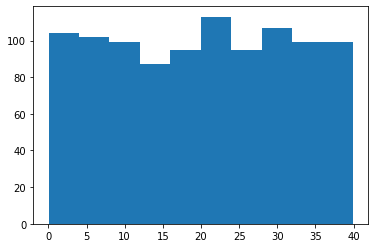

In [181]:
# Declares parameters
a = 0
b = 40
mu0 = 78
tau = 10
n_samples = 1000

# Declares prior distribution for sigma
prior_sigma = uniform(a,b)
prior_samples_sigma = prior_sigma.rvs(n_samples)

# Plots distribution
plt.hist(prior_samples_sigma)
plt.plot()

[]

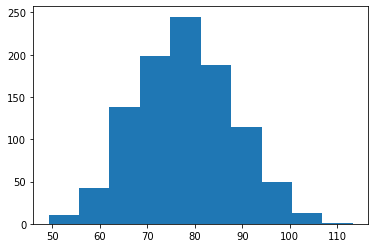

In [182]:
# Declares prior distribution for mu
prior_mu = norm(mu0,tau)
prior_samples_mu = prior_mu.rvs(1000)

# Plots distribution
plt.hist(prior_samples_mu)
plt.plot()

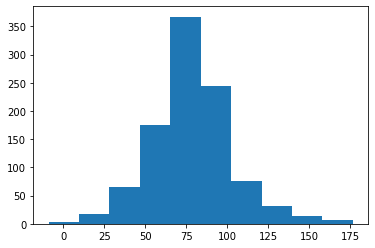

In [183]:
# Declares the prior distribution of sigma and mu in the case of a simulator 
# of a (mu, sigma) distribution 
sigma = uniform.rvs(a, b, n_samples)
mu = norm.rvs(mu0, np.sqrt(tau**2), n_samples)

# Defins the simulator by sampling from both distributions
MESs = []
for i in range(n_samples):
    MESs.append(norm.rvs(mu[i],sigma[i],1))

plt.hist(np.array(MESs))
plt.show()

This looks close to the original MES data, we now want to integrate our data in a model, therefore we need to specify our likelihood:

$$p(y|\mu,\sigma^2) = N(y|\mu,\sigma^2)$$

We will use the *Laplace approximation*, as implemented in the toolbox *tools.py* (this function takes the as input the priors and the likelihood of our model, and gives us back an approximation of the posterior under the form of a Gaussian distribution fitting our posterior parameter space). So, the posterior Gaussian will have dimension equal to the number of parameters. We have:

\begin{align}
P(\mu, \sigma|MES_i, a, b, \mu_0, \sigma_0) &\approx P(MES_i|\mu,\sigma).p(\mu, \sigma|a,b,\mu_0, \sigma_0)\\
&\approx \mathcal{N}([\mu^*, \sigma^*], \Sigma)\\
\end{align}

In [184]:
# We specify a likelihood N(\mu, \sigma^2)

# data likelihood parameter initial values for the parameters mu and sigma2
mu = 40
sigma = 20 

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = mu0
prior_mu_sigma = tau
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

sigma_inf = a
sigma_sup = b
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

solution = laplace_solution([mu,sigma], [], data["midterm"], likelihood, [prior_mu, prior_sigma])

      fun: 197.98215316733882
 hess_inv: array([[1.68484275, 0.01100917],
       [0.01100917, 0.86952408]])
      jac: array([ 5.72204590e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([78.58590676,  9.53992092])


It seems that the machine worked correctly. As such, let's now explore in detail what we obtained. The solution is composed by the mean and the covariance of the posterior, in our case for the parameters $\mu$ and $\sigma$. We can therefore sample from the posterior to explore our new model of `Midterm Scores`:

[]

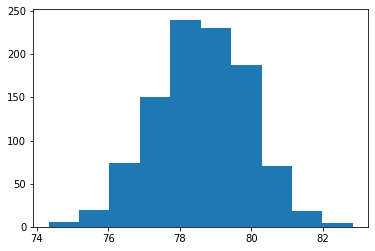

In [185]:
# Samples the posterior distribution of MES
posterior_mean = solution[0]
posterior_covariance = solution[1]
posterior_samples = multivariate_normal.rvs(posterior_mean, 
                                            posterior_covariance, 
                                            size = n_samples)

# Plots the posterior distribution for mu
plt.hist(np.array([posterior_samples[i][0] for i in range(n_samples)]))
plt.plot()

[]

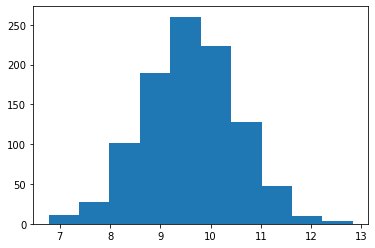

In [186]:
# Plots the posterior distribution for mu
plt.hist(np.array([posterior_samples[i][1] for i in range(n_samples)]))
plt.plot()

Given this data exploration, we settle on the following priors

| prior parameter | Mean | Sigma | distribution |
| --- | --- | --- | --- |
| a | 40 | 20 | Gaussian |
| b | 0 | 10 | Gaussian |
| Sigma | 0 | 40 | Uniform | 

### (6.2) Fit a regression model using these priors (you can use either our Laplace implementation or Stan)

In [188]:
expr = 'final ~ midterm'

# Intializes the likelihood
likelihood = 'gaussian'

# Defins the prior with hyperparameters 
prior_a_mean = 40
prior_a_sigma = 20
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 40
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data, likelihood, priors)

      fun: 223.987848768439
 hess_inv: array([[ 1.02015560e+01, -1.29569865e-01, -1.90463115e+00],
       [-1.29569865e-01,  2.14094242e-03,  2.55568680e-02],
       [-1.90463115e+00,  2.55568680e-02,  2.31339384e+00]])
      jac: array([ 0.0000000e+00, -5.7220459e-06,  0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 152
      nit: 34
     njev: 38
   status: 0
  success: True
        x: array([54.45072857,  0.82969159, 14.51611753])


### (6.3) Sample from the posterior and plot the related regression function. Is this simulation compatible with the observations?

We first sample from the posterior and compute the related statistics.

In [189]:
# Computes the posterior samples
posterior_samples = multivariate_normal.rvs(solution_regression[0], 
                                            solution_regression[1], 
                                            size = n_samples)

# Computes and prints the summary stats
# 85% confidence interval
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# sd
post_sd = np.std(posterior_samples, axis = 0)
# mean
post_mean = np.mean(posterior_samples, axis = 0)
summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]
summary = pd.DataFrame(summary_stats).transpose()
summary.columns = ['mean', 'SD', '7.5%', '92.5%']
summary.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary)

            mean        SD       7.5%      92.5%
a      54.483641  3.166758  49.728933  58.940662
b       0.829147  0.046432   0.765164   0.897967
sigma  14.563872  1.443330  12.527530  16.578456


We can now sample from the posterior and plot the resulting regression function with the variability of the prediction.

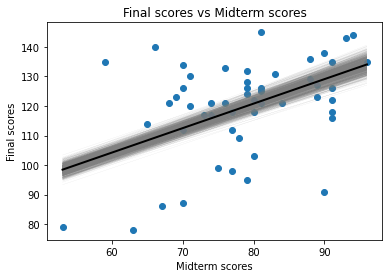

In [190]:
x_range = np.linspace(min(data["midterm"]), max(data["midterm"]))
mean_prediction = post_mean[0] + post_mean[1] * x_range

for i in range(n_samples):
    prediction = posterior_samples[i,0] + posterior_samples[i,1] * x_range
    plt.plot(x_range, prediction, lw = 0.05, color = 'grey')

plt.scatter(data["midterm"],data["final"])
plt.plot(x_range, mean_prediction, lw = 2, color = 'black')
plt.title('Final scores vs Midterm scores')
plt.ylabel('Final scores')
plt.xlabel('Midterm scores')

plt.show()

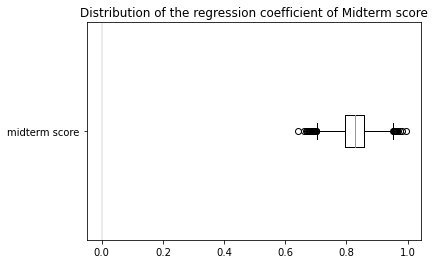

In [191]:
def plot_boxplot_regression(solution,depvar_name,plot_title):
    """
    Plots the confidence interval of the b (slope) parameter
    within an univariate regression between two variables. It
    allows to see if the confidence interval overlaps or falls
    away from zero.
    """
    # Samples the posterior distribution of the slope b as part
    # of an univarite regression
    boxes = posterior_sampling_laplace(solution, 5000)[:,1]
    # Plots the boxplot
    plt.figure()
    plt.boxplot(boxes,vert=0)
    plt.yticks([1], [depvar_name])
    plt.axvline(x=0, color = "black", alpha = 0.1)
    plt.title(plot_title)
    plt.show()
    
plot_boxplot_regression(
    solution_regression, 
    "midterm score", 
    "Distribution of the regression coefficient of Midterm score"
)

At first glance the linear regression results seem to conform with our observations. 

However, we must note that the dataset seems to have a high variance in terms of final score given a midterm score. We can see this by looking at the correlation coefficient between the two columns

In [192]:
np.corrcoef(data[["midterm", "final"]].T)

array([[1.        , 0.42093045],
       [0.42093045, 1.        ]])

### (6.4) Compute the standard deviation for the final score of a student with midterm score of 60.

We try to run the model again by centering the data.

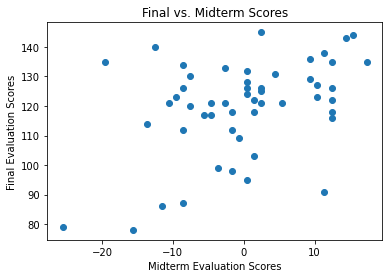

In [193]:
# Centers the data
MES_center = np.mean(data["midterm"])
data_center = data
data_center["midterm"] = data["midterm"] - MES_center

plt.scatter(data_center["midterm"], data_center["final"])
plt.title('Final vs. Midterm Scores')
plt.xlabel('Midterm Evaluation Scores')
plt.ylabel('Final Evaluation Scores')
plt.show()

We can then fit the model again and compute posterior samples.

In [194]:
# Fits the model again
solution_regression_center = laplace_solution_regression(expr, data_center, likelihood, priors)

# Samples from the posterior to explore the distribution of the model parameters
posterior_samples_center = multivariate_normal.rvs(solution_regression_center[0], 
                                                   solution_regression_center[1], 
                                                   size = n_samples)

      fun: 231.42629999721626
 hess_inv: array([[ 3.8385889 , -0.0206203 , -0.26597702],
       [-0.0206203 ,  0.04974453, -0.01546806],
       [-0.26597702, -0.01546806,  2.13684499]])
      jac: array([-1.90734863e-06,  1.90734863e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 23
     njev: 24
   status: 0
  success: True
        x: array([119.01042298,   0.70332224,  14.48743146])


From the resulting regression and sampling, we can compute the `final score` distribution for a student with a `midterm score`of 60. 

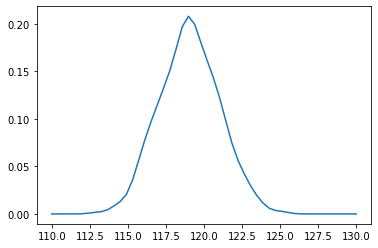

The final score standard deviation of student with midterm score of 60: 1.952562437313759


In [198]:
# Predicts the FES on score distribution of a student with a MES of 60

MES = 60
MES_center = MES - np.mean(MES)
predictions = []
for i in range(n_samples):
    predictions.append(posterior_samples_center[i,0] + posterior_samples_center[i,1] * MES_center)

data_density = gaussian_kde(predictions)
plt.plot(np.linspace(110, 130), data_density(np.linspace(110, 130)))
plt.show()

# Prints the standard deviation
print(f"The final score standard deviation of student with midterm score of 60: {np.std(predictions)}")

## Exercise 7

### From the exercise above, fit a quadratic model and compare it to the linear one for this regression problem.

We start with declaring our quadratic regression function while reusing the priors for $a$, $b$, and $\sigma$ from the linear results above.

In [199]:
data['midterm2'] = data["midterm"] * data["midterm"]
print("Mean and standard deviation of the variable midterm^2:",
      np.mean(data["midterm2"]),
      np.std(data["midterm2"]))

Mean and standard deviation of the variable midterm^2: 91.00998520710057 117.5098162864182


In [200]:
expr = "final ~ midterm + midterm2"

# Initializes the likelihood
likelihood = 'gaussian'

# Defines the prior with hyperparameters 
prior_b2_mean = 90
prior_b2_sigma = 100
prior_b2 = ['gaussian', [prior_b2_mean, prior_b2_sigma]]
priors = [prior_a, prior_b, prior_b2, prior_sigma]

# Runs the regression
solution_regression_quadratic = laplace_solution_regression(expr, data, likelihood, priors)

/home/quentin/anaconda3/envs/pystan_env/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/envs/pystan_env/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 237.3394851807272
 hess_inv: array([[ 6.39903786e+00, -4.83405222e-02, -2.82140667e-02,
        -3.64837804e-01],
       [-4.83405222e-02,  4.70238444e-02,  7.01211923e-04,
         1.46625356e-02],
       [-2.82140667e-02,  7.01211923e-04,  3.12668045e-04,
         2.38968721e-03],
       [-3.64837804e-01,  1.46625356e-02,  2.38968721e-03,
         1.95766387e+00]])
      jac: array([0.00000000e+00, 1.90734863e-06, 3.81469727e-06, 5.72204590e-06])
  message: 'Optimization terminated successfully.'
     nfev: 333
      nit: 56
     njev: 65
   status: 0
  success: True
        x: array([ 1.19292595e+02,  6.95796168e-01, -3.10750161e-03,  1.44674618e+01])


To compare the linear and quadratic models, we want to compute their relative WAIC metric. to do so, we reuse the function we previously used in assignment 2.

In [201]:
def compute_WAIC(depvar_name,covar_name,max_order, 
                 n_sampling,posterior_samples, data):
    """
    Computes the WAIC metric for a set of regression model, given
    a maximum function order (linear, quadratic, cubic or fourth-order),
    posterior sampling parameters, and a dataset.
    """
    # Declares the pointwise predictive distribution and widely 
    # applicable information criterion objects to record
    lppd = []
    p_waic = []
    # Computes the log-probability for each datapoint of the 
    # dependent variable
    for i, target in enumerate(data[depvar_name]):
        # declares a lambda function computing the mean of the 
        # log pdf
        prediction = lambda s, order: posterior_samples[s, 0] + \
                     np.sum([posterior_samples[s,o] * \
                             data[f"{covar_name}{o}"][i]
                             for o in range(1, order+1)], 
                            axis = 0)
        # Computes the log-proba of the datapoint given a sampling size
        log_p = [norm.logpdf(target, loc=prediction(s, max_order), 
                             scale=posterior_samples[s, -1]) 
                 for s in range(n_sampling)]
        # Appends the results
        lppd.append(logsumexp(log_p) - np.log(len(log_p)))
        p_waic.append(np.var(log_p))
    return lppd, p_waic
    
def summarize_WAIC_statistics(depvar_name,covar_name,max_order, 
                              n_sampling,posterior_samples, data):
    """
    Computes the summary of the statistic yielded with the WAIC
    method: WAIC, pWAIC, dWAIC, weight, SE, d_SE
    """
    # Declares empty variable lists for the WAIC and SE
    waic_models = []
    waic_vect_models = []
    p_waic_models = []
    se_models = []
    # For each model (with a given order), computes the WAIC and SE
    # and stores them
    for i in range(1, max_order+1):
        lppd, p_waic = compute_WAIC(depvar_name, covar_name, 
                                    i, n_sampling, 
                                    posterior_samples[i-1], data)
        waic_vect = -2*(np.array(lppd) - np.array(p_waic))
        waic = sum(waic_vect)
        p_waic = sum(p_waic)
        se = np.sqrt(len(data[depvar_name]) * np.var(waic_vect))
        # Records the results
        waic_models.append(waic)
        waic_vect_models.append(waic_vect)
        p_waic_models.append(p_waic)
        se_models.append(se)
    waic_models = np.array(waic_models)
    # Declares empty variables lists for the rest of the statistics
    d_waic = np.zeros(waic_models.shape)
    weights = np.zeros(waic_models.shape)
    d_se = np.zeros(waic_models.shape)
    # Computes the statistics
    for i in range(len(waic_models)):
        d_waic[i] = np.abs(waic_models[i] - min(waic_models))
    min_index = np.argmin(d_waic)
    for i in range(len(waic_models)):
        weights[i] = np.exp(-0.5*d_waic[i]) / \
                     (np.sum(np.exp(-0.5*d_waic)))
        if i != min_index:
            d_se[i] = np.sqrt(len(data[depvar_name])* \
                              np.var(waic_vect_models[i] - \
                                     waic_vect_models[min_index]))
        else:
            d_se[i] = np.nan
    # Prints the summary
    summary_stats = [waic_models, p_waic_models, 
                     d_waic, weights, se_models, d_se]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ["WAIC", "pWAIC", "dWAIC", 
                             "weight", "SE", "d_SE"]
    summary_stats.index = [f"model{o}" for o in range(1, max_order+1)]
    print(summary_stats)
    
def summarize(
    solution, 
    n_samples,
    names={0:'a',1:'b', 2:'sigma'}, 
    plot=False,
) -> tuple:
    """
    Summarizes the regression statistics obtained via a
    Laplace approximation.
    """
    # Computes posterior samples
    posterior_samples = posterior_sampling_laplace(
        solution, n_samples
    )
    #### Computes summary stats
    #    85% confidence interval
    post_quantiles = np.quantile(posterior_samples, 
                                 q = [0.075, 0.925], 
                                 axis = 0)
    #    standard deviation
    post_sd = np.std(posterior_samples, axis = 0)
    #     mean
    post_mean = np.mean(posterior_samples, axis = 0)
    # Prints the results
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],
                     post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.rename(index=names, inplace=True)
    print(summary_stats, "\n")
    # If requested, prints the plot of the posterior data
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()
    # Returns the posterior samples
    return post_mean, post_sd, posterior_samples

def summarize_WAIC_statistics_different_models(
    depvar_name: str,
    n_sampling: int,
    data: pd.DataFrame,
    expressions: dict,
    solutions: list
):
    """
    Computes the summary of the statistic yielded with the WAIC
    method: WAIC, pWAIC, dWAIC, weight, SE, d_SE for models using
    different covariates.
    """
    # Declares empty variable lists for the WAIC and SE
    waic_models = []
    waic_vect_models = []
    p_waic_models = []
    se_models = []
    for i, model in enumerate(expressions):
        lppd = []
        p_waic = []
        # Initializing the likelihood
        likelihood = 'gaussian'
        posterior_samples = posterior_sampling_laplace(
            solutions[i], n_sampling
        )
        for t, target in enumerate(data[depvar_name]):
            log_p = []
            for l in range(n_sampling):
                pred = posterior_samples[l,0] 
                for i, elem in enumerate(list(
                    expressions[model][1].values()
                )[1:-1]):
                    pred += posterior_samples[l,i]*data[elem][t]
                log_p.append(norm.logpdf(
                    target, loc=pred, scale=posterior_samples[l,-1]
                ))
            lppd.append(logsumexp(log_p) - np.log(len(log_p)))
            p_waic.append(np.var(log_p))
        waic_vect = -2*(np.array(lppd) - np.array(p_waic))
        waic = -2*(np.sum(lppd) - np.sum(p_waic))
        p_waic = np.sum(p_waic)
        se = np.sqrt(len(data[depvar_name])*np.var(waic_vect))
        # Records the results
        waic_models.append(waic)
        waic_vect_models.append(waic_vect)
        p_waic_models.append(p_waic)
        se_models.append(se)
    waic_models = np.array(waic_models)
    # Declares empty variables lists for the rest of the statistics
    d_waic = np.zeros(waic_models.shape)
    weights = np.zeros(waic_models.shape)
    d_se = np.zeros(waic_models.shape)
    # Computes the statistics
    for i in range(len(waic_models)):
        d_waic[i] = np.abs(waic_models[i] - min(waic_models))
    min_index = np.argmin(d_waic)
    for i in range(len(waic_models)):
        weights[i] = np.exp(-0.5*d_waic[i]) / (np.sum(np.exp(-0.5*d_waic)))
        if i != min_index:
            d_se[i] = np.sqrt(len(data[depvar_name])* \
                              np.var(waic_vect_models[i] - \
                                     waic_vect_models[min_index]))
        else:
            d_se[i] = np.nan
    # Prints the summary
    summary_stats = [waic_models, p_waic_models, d_waic, 
                     weights, se_models, d_se]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ["WAIC", "pWAIC", "dWAIC", 
                             "weight", "SE", "d_SE"]
    summary_stats.index = list(expressions.keys())
    print(summary_stats)

Regression results for linear model:
            mean        SD       7.5%      92.5%
a      54.280701  3.200987  49.731948  58.961132
b       0.830469  0.045917   0.765644   0.895275
sigma  14.614297  1.537766  12.446096  16.921333 



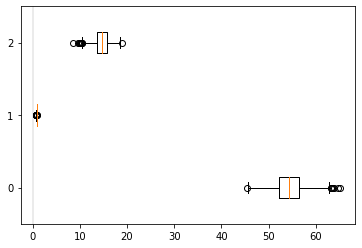



Regression results for quadratic model:
             mean        SD        7.5%       92.5%
a      119.237062  2.506473  115.816387  122.939908
b        0.696282  0.216638    0.376736    1.001686
b2      -0.003121  0.017928   -0.028135    0.023048
sigma   14.556229  1.401540   12.569674   16.569967 



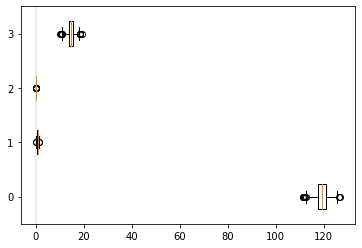

In [202]:
# Concatenates the informations from our two models
expressions = {
    "linear_model" : ["final ~ midterm", {0:"a", 1:"midterm", 2:"sigma"}],
    "quadratic_model" : ["final ~ midterm + midterm2", {0:"a", 1:"midterm", 2: "midterm2", 3: "sigma"}]}
solutions = [solution_regression, solution_regression_quadratic]
posterior_samples = [posterior_sampling_laplace(solutions[i], n_samples)
                     for i in range(2)]

# Prints the summary of each model
print(f"Regression results for linear model:")
_, _, _ = summarize(solutions[0], n_samples, plot=True); print("\n")
print(f"Regression results for quadratic model:")
_, _, _ = summarize(solutions[1], n_samples, plot=True,
                    names={0:'a',1:'b', 2:'b2', 3:'sigma'}); print("\n")

In [203]:
# Computes the WAIC for the two models

summarize_WAIC_statistics_different_models(
    "final", n_samples, data, expressions, solutions
)

                         WAIC         pWAIC         dWAIC  weight  \
linear_model     1.230447e+07  6.136841e+06  0.000000e+00     1.0   
quadratic_model  1.281773e+08  6.400263e+07  1.158728e+08     0.0   

                           SE          d_SE  
linear_model     5.072858e+06           NaN  
quadratic_model  4.026535e+07  3.551408e+07  


Even though the 95% confidence interval for the coefficient of the variable `midterm^2` tends to straddle both positive and negative values, we obtain a better WAIC with the quadratic model. As such, we might want to go with the quadratic model.

As we previously noted, the dataset seems to have a very high variance (for a given midterm score, the range of resulting final score seems large). this might put into question using a regression or quadratic model as it risks to hardly fit the data given the involved noise.

## Exercise 8

The file *data_exam.csv* contains the data from a clinical study on neurodegenerative diseases.
The variables that we investigate are the following:

- DX: diagnosis (normal - NL - or Dementia)

- PTGENDER: sex (male or female)

- AGE

- APOE4: genetic risk factor (non carrier - 0 - or carrier - 1 -)

- ADAS13: clinical score (the higher the more pathological/dementia)

Questions:

- (8.1) What is a reasonable likelihood function to mode the probability of Dementia diagnosis as a function of ADAS13? 
- (8.2) According to your reply to question 8.1, fit a model for the probability of Dementia as a function of ADAS13;
- (8.3) Compute the training accuracy of the the predictions against the data, and verify that the model gives plausible results;
- (8.4) Find a 95% confidence interval for the Dementia probability of a patient with ADAS13 equal to 15;
- (8.5) Find a 95% confidence interval for the Dementia probability of a patient with ADAS13 equal to 20;
- (8.6) Find a 95% confidence interval for the difference between probabilities. Is the difference between the dementia risk of these two patients significant? 


In [206]:
data = pd.read_csv('data_exam.csv').dropna().drop('Unnamed: 0', axis =1)
data = data.replace({'DX': {'NL': 0, 'Dementia': 1}, 'PTGENDER': {'Male': 0, 'Female': 1}})

In [207]:
data

,PTGENDER,ADAS13,APOE4,AGE,DX
0,0,18.67,0.0,74.3,0
1,0,31.00,1.0,81.3,1
2,0,14.67,0.0,73.7,0
3,0,40.33,1.0,75.4,1
4,1,7.00,0.0,84.5,0
...,...,...,...,...,...
852,1,6.00,1.0,67.0,0
853,1,5.00,0.0,74.3,0
854,0,11.00,1.0,68.5,0
855,1,18.00,1.0,75.5,0


In [209]:
data.describe()

,PTGENDER,ADAS13,APOE4,AGE,DX
count,846.000000,846.000000,846.000000,846.000000,846.000000
mean,0.489362,17.222612,0.520095,74.508629,0.385343
std,0.500183,11.755629,0.655571,6.622993,0.486964
min,0.000000,0.000000,0.000000,55.100000,0.000000
25%,0.000000,8.000000,0.000000,70.525000,0.000000
50%,0.000000,13.000000,0.000000,74.300000,0.000000
75%,1.000000,26.330000,1.000000,78.900000,1.000000
max,1.000000,54.670000,2.000000,90.900000,1.000000


### (8.1) What is a reasonable likelihood function to model the probability of Dementia diagnosis as a function of ADAS13? 


We are in a classification modeling setup where we want to estimate the probability of a patient having dementia. Having the disease or not corresponds to classes (e.g. 0 or 1). In such a setup, where we want to estimate $y$ the probabilty of being affected, the Binomial model is the most fitting one here s.t.:

\begin{align}
\mathbb{P}(y)&\sim\mathcal{B}(n,p),\,\text{a binomial likelihood model}\\
\text{with}&,\\
p&,\,\text{the probability of a patient being diagnosed with dementia}\\
y&,\,\text{the number of positive cases}\\
n&,\,\text{the number of trials/individuals}
\end{align}

In the following case, we will use the Binomial distribution for our likelihood model. A 1-predictor Binomial model is parametrized by the probability $p$ itself parametrized as a linear combination of the predictor $x$ s.t.:

\begin{align}
y_i &\sim \mathcal{B}(n, p_i)\\
f(p_i) &= a + b x_i
\end{align}

As noted in class, there are some issues to account for: 

- Since the probability $p_i$ must be bounded in the interval $[0,1]$, parameterizing it directly with a linear model will likely result in breaking the basic rules of probabilities.
- We have no guarantee at the moment that the linear $f(p_i)$ combination is bounded in the interval $[0,1]$.
- As such, the probability $p_i$ must be adapted to be contained in the interval $[0,1]$ via a link function: 
    - The logit which, when included as below, can be rewritten into a new, convenient estimation of $p_i$:

\begin{align}
logit(p_i) &= \log(\frac{p_i}{1-p_i})\\
\log(\frac{p_i}{1-p_i}) &= a + b x_i\\
p_i &= \frac{\exp(a + b x_i)}{1 + \exp(a + b x_i)}
\end{align}

In our case, We want to fit the dependent variable `DX` with the covariate `ADAS13`. As such, we are interested in a logistic regression model for predicting dementia given one predictors $x$ such as above:

\begin{align}
y_i &\sim \mathcal{B}(n, p_i)\\
p_i &= \frac{\exp(a + b x_i)}{1 + \exp(a + b x_i)}
\end{align}

For exploration and comparison purposes, we will fit `DX` with `ADAS13` with the prior parameters $a$ and $b$ of the regression modelled with Gaussian prior and $y$ (the `DX` variable) by a binomial.

We will rely on PyStan.

### (8.2) According to your reply to question 8.1, fit a model for the probability of Dementia as a function of ADAS13

Reusing the PyStan implementation from assignment 3. We have:

In [212]:
def run_pystan_modeling(
    data: pd.DataFrame, 
    model: str, 
    model_data: dict, 
    params_to_plot: list,
    sampling_size = 1000
) -> tuple:
    """
    Compiles a pystan model and runs it on a given dataset and parameters.
    Outputs the boxplot distribution of the generated parameters, and returns
    the generated posterior and WAIC of the model (for comparison).
    """
    # Compiles and fit the model
    stan_model = pystan.StanModel(model_code = model)
    posterior = stan_model.sampling(data=model_data, seed=int(1), 
                                    iter=4000, chains=4)
    # Prints the diagnosis of the fit
    print(f"Post-fitting diagnosis:\n{pystan.check_hmc_diagnostics(posterior)}")
    # Computes the WAIC of the model
    p_i = posterior.extract()['p_i']
    lppd = []; pwaic = []
    for k in range(len(data)):
        id_log_lik = [binom.logpmf(data['DX'].values[k], 1, p_i[i,k]) 
                      for i in range(sampling_size)]
        lppd.append(logsumexp(id_log_lik) - np.log(len(id_log_lik)))
        pwaic.append(np.var(id_log_lik))
    waic = -2 * (np.sum(lppd) - np.sum(pwaic))
    # Plots the distribution of the parameters
    estimators = [posterior.extract()[param] for param in params_to_plot]
    yticks_values = [i+1 for i in range(len(params_to_plot))]
    plt.boxplot(estimators, vert=0)
    plt.yticks(yticks_values, params_to_plot)
    plt.axvline(x=0, color="black", alpha=0.1)
    plt.title(f"Posterior distribution of parameters: {params_to_plot}")
    plt.show()
    # Returns the posterior model and the WAIC
    return posterior, waic

In [213]:
# Declares the pystan model for both:
#    - DX ~ ADAS13
model = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
  real param1_a;
  real<lower=0> param2_a;
  real param1_b;
  real<lower=0> param2_b;
}
parameters {
  real a;
  real b;
}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i])/(1 + exp(a + b * x[i])); 
    }
}
model {
  a ~ normal(param1_a, param2_a);
  b ~ normal(param1_b, param2_b);
  y ~ binomial(1, p_i);
}
"""


# Declares the data to send to the pystan model for
# both covariates DX and ADAS13
stan_data = {"x":        data["ADAS13"],
             "y":        data['DX'],
             "param1_a": 0,  "param2_a": 10,
             "param1_b": 15, "param2_b": 10,
             "N":        data.shape[0]
            }

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d8d383a2106438802a1aa6af68d1a0d NOW.


Post-fitting diagnosis:
{'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': True, 'energy': True}


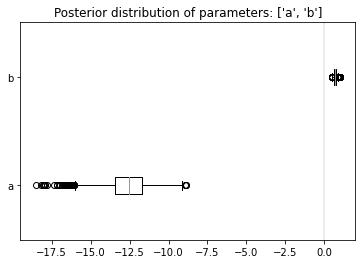

In [214]:
posterior, waic = run_pystan_modeling(
    data, model, stan_data, ["a", "b"]
)

In [215]:
posterior


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_4d8d383a2106438802a1aa6af68d1a0d.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -12.6    0.03   1.29 -15.36 -13.43 -12.52 -11.71 -10.29   1420    1.0
b         0.69  1.9e-3   0.07   0.56   0.64   0.68   0.73   0.84   1413    1.0
p_i[1]    0.55  6.5e-4   0.05   0.45   0.51   0.55   0.59   0.66   6916    1.0
p_i[2]     1.0  6.8e-6 2.7e-4    1.0    1.0    1.0    1.0    1.0   1555    1.0
p_i[3]    0.08  4.5e-4   0.02   0.04   0.06   0.07   0.09   0.12   2199    1.0
p_i[4]     1.0  5.1e-8 1.9e-6    1.0    1.0    1.0    1.0    1.0   1370    1.0
p_i[5]  5.5e-4  1.1e-5 4.5e-4 7.4e-5 2.5e-4 4.3e-4 7.1e-4 1.7e-3   1506    1.0
p_i[6]    0.98  2.1e-4 9.1e-3   0.96   0.98   0.98   0.99   0.99   1853    1.0
p_i[7]  1.3e-3  2.3e-5 9.1e-4 2.3e-4 6.5e-4 1.1e-3 1.7e-3 3.

### (8.3) Compute the training accuracy of the the predictions against the data, and verify that the model gives plausible results

### (8.4) Find a 95% confidence interval for the Dementia probability of a patient with ADAS13 equal to 15

### (8.5) Find a 95% confidence interval for the Dementia probability of a patient with ADAS13 equal to 20


### (8.6) Find a 95% confidence interval for the difference between probabilities. Is the difference between the dementia risk of these two patients significant?